In [2]:
import pandas as pd
import time
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
import sklearn.metrics as metrics
import sklearn.utils as utils
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn import tree
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import graphviz 
import math

In [4]:
dict_classifiers = {
    "Linear Regression": LinearRegression(),
    "Polynomial Regression": LinearRegression(),
#     "Neural Network": MLPRegressor(hidden_layer_sizes=(8,8,8), activation='relu', solver='adam', max_iter=500),
    "Decision Tree": DecisionTreeRegressor(random_state = 0),
    "Decision Tree with Max Depth = 03": DecisionTreeRegressor(max_depth=3, random_state = 0),
    "Decision Tree with Max Depth = 05": DecisionTreeRegressor(max_depth=5, random_state = 0),
    "Decision Tree with Max Depth = 10": DecisionTreeRegressor(max_depth=10, random_state = 0),
    "Decision Tree with Max Depth = 15": DecisionTreeRegressor(max_depth=15, random_state = 0),
#     "Random Forest": RandomForestRegressor(n_estimators=100, random_state=0)
}

In [5]:
def batch_classify(X_train, Y_train, X_test, Y_test, verbose=True, include_y_pred=False):
    """
    This method, takes as input the X, Y matrices of the Train and Test set.
    And fits them on all of the Classifiers specified in the dict_classifier.
    The trained models, and accuracies are saved in a dictionary. The reason to use a dictionary
    is because it is very easy to save the whole dictionary with the pickle module.

    Usually, the SVM, Random Forest and Gradient Boosting Classifier take quiet some time to train.
    So it is best to train them on a smaller dataset first and
    decide whether you want to comment them out or not based on the test accuracy score.
    """

    dict_models = {}
    for classifier_name, classifier in list(dict_classifiers.items()):
        coefs = None
        if classifier_name == "Polynomial Regression":
            poly = PolynomialFeatures(degree=2)
            saved_X_train = X_train
            saved_X_test = X_test
            X_train = poly.fit_transform(X_train)
            X_test = poly.fit_transform(X_test)
        if classifier_name == "Random Forest":
            sc = StandardScaler()
            X_train = sc.fit_transform(X_train)
            X_test = sc.transform(X_test)
        t_start = time.process_time()
        classifier.fit(X_train, Y_train)
        t_end = time.process_time()
        
        if 'Decision Tree' in classifier_name:
            print()

        if classifier_name == "Linear Regression":
            coefs = classifier.coef_
        
        t_diff = t_end - t_start
        train_score = classifier.score(X_train, Y_train)
        Y_pred = classifier.predict(X_test)
        test_score = classifier.score(X_test, Y_test)

        if include_y_pred:
            dict_models[classifier_name] = {'model': classifier_name, 'train_score': train_score,
                                            'test_score': test_score, 'train_time': t_diff, 'y_pred': Y_pred}
        else:
            dict_models[classifier_name] = {'model': classifier_name, 'train_score': train_score,
                                            'test_score': test_score, 'train_time': t_diff, 'coef':coefs}
        if verbose:
            print("trained {c} in {f:.2f} s".format(c=classifier_name, f=t_diff))
        if classifier_name == "Polynomial Regression":
            X_train = saved_X_train
            X_test = saved_X_test
    return dict_models

In [6]:
def scores_calculator(classifiers, model):
    score_dict = {}
    for classifier in classifiers:
        Y_pred_bin = model[classifier]['y_pred'] > 2
        Y_test_bin = Y_test > 2
        true_pos_count = 0
        true_neg_count = 0
        false_pos_count = 0
        false_neg_count = 0
        for i in range(len(Y_pred_bin)):
            if Y_pred_bin[i] == Y_test_bin[i]:
                if Y_pred_bin[i] == True:
                    true_pos_count += 1
                else:
                    true_neg_count += 1
            else:
                if Y_pred_bin[i] == True:
                    false_pos_count += 1
                else:
                    false_neg_count += 1
                    
        accuracy = (true_pos_count + true_neg_count) / len(Y_pred_bin)
        if (true_pos_count + false_neg_count) != 0:
            recall = true_pos_count / (true_pos_count + false_neg_count)
        else:
            recall = None
        if (true_pos_count + false_pos_count) != 0:
            precision = true_pos_count / (true_pos_count + false_pos_count)
        else:
            precision = None
                    
        score_dict[classifier] = {'Accuracy': accuracy, 
                                 'Recall': recall,
                                 'Precision': precision}
        
    return score_dict

In [17]:
files = os.listdir('../Data/rmsds')
first = True
data = pd.read_csv("../Data/rmsds/5HT2B_rmsds.csv")
for file in files:
    if file[-4:] == '.csv' and file != '5HT2B_rmsds.csv':
        fileData = pd.read_csv("../Data/rmsds/" + file)
        data = pd.concat([data, fileData], sort=False)
data = data[data['secondary structure'] != -1]
data = data[data['complete rmsd'] < 30]
prots = sorted(data['protein'].unique())
test_results = []
test_scores = []

for test_prot in prots:
    print(test_prot)
    train_data = data[data['protein'] != test_prot]
    test_data = data[data['protein'] == test_prot]

    X_train = train_data.drop(['protein', 'start ligand', 'target ligand', 'name', 'num', 'complete rmsd', 'backbone rmsd', 
                               'sidechain rmsd'], axis=1).values
    Y_train = train_data['complete rmsd'].values 

    X_test = test_data.drop(['protein', 'start ligand', 'target ligand', 'name', 'num', 'complete rmsd', 'backbone rmsd', 
                             'sidechain rmsd'], axis=1).values
    Y_test = test_data['complete rmsd'].values 

    X_true = X_train[Y_train > 2]
    Y_true = Y_train[Y_train > 2]

    X_train_expanded_50 = np.append(X_train, X_true, axis=0)
    Y_train_expanded_50 = np.append(Y_train, Y_true, axis=0)

    for i in range(4):
        X_train_expanded_50 = np.append(X_train_expanded_50, X_true, axis=0)
        Y_train_expanded_50 = np.append(Y_train_expanded_50, Y_true, axis=0)
        
    dict_models = batch_classify(X_train_expanded_50, Y_train_expanded_50, X_test, Y_test, include_y_pred=True)
    test_results.append(dict_models)
    test_scores.append(scores_calculator(list(dict_classifiers.keys()), dict_models))

MAPK14


,protein,start ligand,target ligand,name,num,bfactor,normalized bfactor,prev prev bfactor,prev bfactor,next bfactor,...,mol weight,solvent accessibility,secondary structure,ligand similarity,ligand similarity ratio,ligand size difference,ligand size ratio,complete rmsd,backbone rmsd,sidechain rmsd
0,5HT2B,4IB4,5TVN,TRP,131,52.945714,-0.932384,-0.750709,-0.548052,-0.953941,...,186.21515,19.665082,1,20,0.465116,19,1.791667,0.369043,0.356275,0.369043
1,5HT2B,4IB4,5TVN,LEU,132,52.298750,-0.953941,-0.932384,-0.750709,-0.851453,...,113.16067,0.689631,1,20,0.465116,19,1.791667,0.335036,0.237031,0.335036
2,5HT2B,4IB4,5TVN,ASP,135,52.543750,-0.945777,-0.943528,-0.851453,-1.085850,...,114.08138,0.443392,1,20,0.465116,19,1.791667,0.894417,0.113218,0.894417
3,5HT2B,4IB4,5TVN,VAL,136,48.340000,-1.085850,-0.945777,-0.943528,-1.076603,...,99.13358,0.119069,1,20,0.465116,19,1.791667,0.160625,0.015321,0.160625
4,5HT2B,4IB4,5TVN,SER,139,46.298333,-1.153880,-1.007546,-1.076603,-1.276112,...,87.07880,0.050330,1,20,0.465116,19,1.791667,0.189813,0.193603,0.189813


In [8]:
avg_scores = {}
counts = {}
recalls = []
tree_depth_05 = {}
for classifier in dict_classifiers:
    avg_scores[classifier] = {'Accuracy':0, 'Recall':0, 'Precision':0}
    counts[classifier] = {'Accuracy':0, 'Recall':0, 'Precision':0}
    

for i, scores in enumerate(test_scores):
    for classifier in scores:
        if classifier == 'Decision Tree with Max Depth = 05':
            tree_depth_05[prots[i]] = {}
        for score_type in scores[classifier]:
            if classifier == 'Decision Tree with Max Depth = 05':
                tree_depth_05[prots[i]][score_type] = scores[classifier][score_type]
            if scores[classifier][score_type] != None:
                avg_scores[classifier][score_type] += scores[classifier][score_type]
                counts[classifier][score_type] += 1
                
for classifier in avg_scores:
    for score_type in avg_scores[classifier]:
        avg_scores[classifier][score_type] /= counts[classifier][score_type]
        
pd.DataFrame.from_dict(tree_depth_05['MAPK14'], orient='index')

,0
Accuracy,0.676357
Recall,0.469579
Precision,0.379342


In [65]:
pd.DataFrame.from_dict(avg_scores, orient='index')

,Accuracy,Recall,Precision
Decision Tree,0.816147,0.261035,0.213735
Decision Tree with Max Depth = 03,0.693032,0.571683,0.185257
Decision Tree with Max Depth = 05,0.751622,0.493069,0.207732
Decision Tree with Max Depth = 10,0.754577,0.468996,0.204921
Decision Tree with Max Depth = 15,0.789862,0.379243,0.226848
Linear Regression,0.651999,0.595269,0.189361
Polynomial Regression,0.682965,0.564445,0.188333


In [22]:
files = os.listdir('../Data/rmsds')
first = True
data = pd.read_csv("../Data/rmsds/5HT2B_rmsds.csv")
for file in files:
    if file[-4:] == '.csv' and file != '5HT2B_rmsds.csv':
        fileData = pd.read_csv("../Data/rmsds/" + file)
        data = pd.concat([data, fileData], sort=False)
data = data[data['secondary structure'] != -1]
data = data[data['complete rmsd'] < 30]
prots = sorted(data['protein'].unique())

# utils.shuffle(prots, random_state=7)

# train_prots = prots[:len(prots) * 66 // 100]
# test_prots = sorted(prots[len(prots) * 66 // 100:])
test_results = []
test_scores = []

for test_prot in prots:
    print(test_prot)
    train_data = data[data['protein'].isin(train_prots)]
    test_data = data[data['protein'] == test_prot]

    X_train = train_data.drop(['protein', 'start ligand', 'target ligand', 'name', 'num', 'complete rmsd', 
                               'backbone rmsd', 'sidechain rmsd'], axis=1).values
    Y_train = train_data['complete rmsd'].values 

    X_test = test_data.drop(['protein', 'start ligand', 'target ligand', 'name', 'num', 'complete rmsd', 
                             'backbone rmsd', 'sidechain rmsd'], axis=1).values
    Y_test = test_data['complete rmsd'].values 

    X_true = X_train[Y_train > 2]
    Y_true = Y_train[Y_train > 2]

    X_train_expanded_50 = np.append(X_train, X_true, axis=0)
    Y_train_expanded_50 = np.append(Y_train, Y_true, axis=0)

    for i in range(4):
        X_train_expanded_50 = np.append(X_train_expanded_50, X_true, axis=0)
        Y_train_expanded_50 = np.append(Y_train_expanded_50, Y_true, axis=0)

    dict_models = batch_classify(X_train_expanded_50, Y_train_expanded_50, X_test, Y_test, include_y_pred=True)
    test_results.append(dict_models)
    test_scores.append(scores_calculator(list(dict_classifiers.keys()), dict_models))

5HT2B
trained Linear Regression in 2.03 s
trained Polynomial Regression in 11.02 s

trained Decision Tree in 6.18 s

trained Decision Tree with Max Depth = 03 in 3.01 s

trained Decision Tree with Max Depth = 05 in 3.54 s

trained Decision Tree with Max Depth = 10 in 4.55 s

trained Decision Tree with Max Depth = 15 in 5.11 s
AR
trained Linear Regression in 1.87 s
trained Polynomial Regression in 10.79 s

trained Decision Tree in 6.31 s

trained Decision Tree with Max Depth = 03 in 2.93 s

trained Decision Tree with Max Depth = 05 in 3.49 s

trained Decision Tree with Max Depth = 10 in 4.40 s

trained Decision Tree with Max Depth = 15 in 5.02 s
B1AR
trained Linear Regression in 1.91 s
trained Polynomial Regression in 10.61 s

trained Decision Tree in 6.29 s

trained Decision Tree with Max Depth = 03 in 2.96 s

trained Decision Tree with Max Depth = 05 in 3.45 s

trained Decision Tree with Max Depth = 10 in 4.58 s

trained Decision Tree with Max Depth = 15 in 5.20 s
B2AR
trained Linear 

trained Polynomial Regression in 10.11 s

trained Decision Tree in 6.12 s

trained Decision Tree with Max Depth = 03 in 2.87 s

trained Decision Tree with Max Depth = 05 in 3.45 s

trained Decision Tree with Max Depth = 10 in 4.31 s

trained Decision Tree with Max Depth = 15 in 4.98 s
PLAU
trained Linear Regression in 1.76 s
trained Polynomial Regression in 10.16 s

trained Decision Tree in 6.07 s

trained Decision Tree with Max Depth = 03 in 2.87 s

trained Decision Tree with Max Depth = 05 in 3.40 s

trained Decision Tree with Max Depth = 10 in 4.31 s

trained Decision Tree with Max Depth = 15 in 4.98 s
PLK1
trained Linear Regression in 1.79 s
trained Polynomial Regression in 10.26 s

trained Decision Tree in 6.12 s

trained Decision Tree with Max Depth = 03 in 2.93 s

trained Decision Tree with Max Depth = 05 in 3.46 s

trained Decision Tree with Max Depth = 10 in 4.32 s

trained Decision Tree with Max Depth = 15 in 5.00 s
PTPN1
trained Linear Regression in 1.77 s
trained Polynomial

In [26]:
files = os.listdir('../Data/rmsds')
first = True
data = pd.read_csv("../Data/rmsds/5HT2B_rmsds.csv")
for file in files:
    if file[-4:] == '.csv' and file != '5HT2B_rmsds.csv':
        fileData = pd.read_csv("../Data/rmsds/" + file)
        data = pd.concat([data, fileData], sort=False)
data = data[data['secondary structure'] != -1]
data = data[data['complete rmsd'] < 30]
prots = sorted(data['protein'].unique())

# utils.shuffle(prots, random_state=7)

# train_prots = prots[:len(prots) * 66 // 100]
# test_prots = sorted(prots[len(prots) * 66 // 100:])
test_results = []
test_scores = []

for test_prot in prots:
    print(test_prot)
    train_data = data[data['protein'].isin(train_prots)]
    test_data = data[data['protein'] == test_prot]

    X_train = train_data.drop(['protein', 'start ligand', 'target ligand', 'name', 'num', 'complete rmsd', 
                               'backbone rmsd', 'sidechain rmsd'], axis=1).values
    Y_train = train_data['backbone rmsd'].values 

    X_test = test_data.drop(['protein', 'start ligand', 'target ligand', 'name', 'num', 'complete rmsd', 
                             'backbone rmsd', 'sidechain rmsd'], axis=1).values
    Y_test = test_data['backbone rmsd'].values 

    X_true = X_train[Y_train > 2]
    Y_true = Y_train[Y_train > 2]

    X_train_expanded_50 = np.append(X_train, X_true, axis=0)
    Y_train_expanded_50 = np.append(Y_train, Y_true, axis=0)

    for i in range(4):
        X_train_expanded_50 = np.append(X_train_expanded_50, X_true, axis=0)
        Y_train_expanded_50 = np.append(Y_train_expanded_50, Y_true, axis=0)

    dict_models = batch_classify(X_train_expanded_50, Y_train_expanded_50, X_test, Y_test, include_y_pred=True)
    test_results.append(dict_models)
    test_scores.append(scores_calculator(list(dict_classifiers.keys()), dict_models))

5HT2B
trained Linear Regression in 0.72 s
trained Polynomial Regression in 7.20 s

trained Decision Tree in 5.19 s

trained Decision Tree with Max Depth = 03 in 2.64 s

trained Decision Tree with Max Depth = 05 in 3.02 s

trained Decision Tree with Max Depth = 10 in 3.63 s

trained Decision Tree with Max Depth = 15 in 4.27 s
AR
trained Linear Regression in 0.75 s
trained Polynomial Regression in 7.34 s

trained Decision Tree in 5.21 s

trained Decision Tree with Max Depth = 03 in 2.57 s

trained Decision Tree with Max Depth = 05 in 2.95 s

trained Decision Tree with Max Depth = 10 in 3.67 s

trained Decision Tree with Max Depth = 15 in 4.14 s
B1AR
trained Linear Regression in 0.75 s
trained Polynomial Regression in 7.48 s

trained Decision Tree in 5.30 s

trained Decision Tree with Max Depth = 03 in 2.57 s

trained Decision Tree with Max Depth = 05 in 2.92 s

trained Decision Tree with Max Depth = 10 in 3.58 s

trained Decision Tree with Max Depth = 15 in 4.16 s
B2AR
trained Linear Reg

trained Polynomial Regression in 7.21 s

trained Decision Tree in 5.15 s

trained Decision Tree with Max Depth = 03 in 2.56 s

trained Decision Tree with Max Depth = 05 in 2.89 s

trained Decision Tree with Max Depth = 10 in 3.57 s

trained Decision Tree with Max Depth = 15 in 4.17 s
PLAU
trained Linear Regression in 0.71 s
trained Polynomial Regression in 7.73 s

trained Decision Tree in 5.25 s

trained Decision Tree with Max Depth = 03 in 2.53 s

trained Decision Tree with Max Depth = 05 in 2.96 s

trained Decision Tree with Max Depth = 10 in 3.59 s

trained Decision Tree with Max Depth = 15 in 4.24 s
PLK1
trained Linear Regression in 0.75 s
trained Polynomial Regression in 7.28 s

trained Decision Tree in 5.19 s

trained Decision Tree with Max Depth = 03 in 2.62 s

trained Decision Tree with Max Depth = 05 in 2.95 s

trained Decision Tree with Max Depth = 10 in 3.63 s

trained Decision Tree with Max Depth = 15 in 4.17 s
PTPN1
trained Linear Regression in 0.75 s
trained Polynomial Re

In [28]:
files = os.listdir('../Data/rmsds')
first = True
data = pd.read_csv("../Data/rmsds/5HT2B_rmsds.csv")
for file in files:
    if file[-4:] == '.csv' and file != '5HT2B_rmsds.csv':
        fileData = pd.read_csv("../Data/rmsds/" + file)
        data = pd.concat([data, fileData], sort=False)
data = data[data['secondary structure'] != -1]
data = data[data['complete rmsd'] < 30]
prots = sorted(data['protein'].unique())

# utils.shuffle(prots, random_state=7)

# train_prots = prots[:len(prots) * 66 // 100]
# test_prots = sorted(prots[len(prots) * 66 // 100:])
test_results = []
test_scores = []

for test_prot in prots:
    print(test_prot)
    train_data = data[data['protein'].isin(train_prots)]
    test_data = data[data['protein'] == test_prot]

    X_train = train_data.drop(['protein', 'start ligand', 'target ligand', 'name', 'num', 'complete rmsd', 
                               'backbone rmsd', 'sidechain rmsd'], axis=1).values
    Y_train = train_data['sidechain rmsd'].values 

    X_test = test_data.drop(['protein', 'start ligand', 'target ligand', 'name', 'num', 'complete rmsd', 
                             'backbone rmsd', 'sidechain rmsd'], axis=1).values
    Y_test = test_data['sidechain rmsd'].values 

    X_true = X_train[Y_train > 2]
    Y_true = Y_train[Y_train > 2]

    X_train_expanded_50 = np.append(X_train, X_true, axis=0)
    Y_train_expanded_50 = np.append(Y_train, Y_true, axis=0)

    for i in range(4):
        X_train_expanded_50 = np.append(X_train_expanded_50, X_true, axis=0)
        Y_train_expanded_50 = np.append(Y_train_expanded_50, Y_true, axis=0)

    dict_models = batch_classify(X_train_expanded_50, Y_train_expanded_50, X_test, Y_test, include_y_pred=True)
    test_results.append(dict_models)
    test_scores.append(scores_calculator(list(dict_classifiers.keys()), dict_models))

5HT2B
trained Linear Regression in 1.95 s
trained Polynomial Regression in 11.11 s

trained Decision Tree in 6.07 s

trained Decision Tree with Max Depth = 03 in 2.94 s

trained Decision Tree with Max Depth = 05 in 3.44 s

trained Decision Tree with Max Depth = 10 in 4.33 s

trained Decision Tree with Max Depth = 15 in 5.02 s
AR
trained Linear Regression in 1.87 s
trained Polynomial Regression in 10.34 s

trained Decision Tree in 6.09 s

trained Decision Tree with Max Depth = 03 in 2.88 s

trained Decision Tree with Max Depth = 05 in 3.40 s

trained Decision Tree with Max Depth = 10 in 4.32 s

trained Decision Tree with Max Depth = 15 in 5.03 s
B1AR
trained Linear Regression in 1.81 s
trained Polynomial Regression in 10.30 s

trained Decision Tree in 6.08 s

trained Decision Tree with Max Depth = 03 in 2.91 s

trained Decision Tree with Max Depth = 05 in 3.42 s

trained Decision Tree with Max Depth = 10 in 4.37 s

trained Decision Tree with Max Depth = 15 in 5.00 s
B2AR
trained Linear 

trained Polynomial Regression in 10.48 s

trained Decision Tree in 6.23 s

trained Decision Tree with Max Depth = 03 in 2.95 s

trained Decision Tree with Max Depth = 05 in 3.46 s

trained Decision Tree with Max Depth = 10 in 4.42 s

trained Decision Tree with Max Depth = 15 in 5.13 s
PLAU
trained Linear Regression in 2.07 s
trained Polynomial Regression in 10.54 s

trained Decision Tree in 6.23 s

trained Decision Tree with Max Depth = 03 in 2.88 s

trained Decision Tree with Max Depth = 05 in 3.43 s

trained Decision Tree with Max Depth = 10 in 4.49 s

trained Decision Tree with Max Depth = 15 in 5.21 s
PLK1
trained Linear Regression in 1.92 s
trained Polynomial Regression in 10.27 s

trained Decision Tree in 6.16 s

trained Decision Tree with Max Depth = 03 in 2.95 s

trained Decision Tree with Max Depth = 05 in 3.45 s

trained Decision Tree with Max Depth = 10 in 4.51 s

trained Decision Tree with Max Depth = 15 in 5.15 s
PTPN1
trained Linear Regression in 1.94 s
trained Polynomial

In [25]:
print("Complete RMSD:")
avg_scores = {}
counts = {}
recalls = []
tree_depth_05 = {}
for classifier in dict_classifiers:
    avg_scores[classifier] = {'Accuracy':0, 'Recall':0, 'Precision':0}
    counts[classifier] = {'Accuracy':0, 'Recall':0, 'Precision':0}
    

for i, scores in enumerate(test_scores):
    for classifier in scores:
        if classifier == 'Decision Tree with Max Depth = 05':
            tree_depth_05[prots[i]] = {}
        for score_type in scores[classifier]:
            if classifier == 'Decision Tree with Max Depth = 05':
                tree_depth_05[prots[i]][score_type] = scores[classifier][score_type]
            if scores[classifier][score_type] != None:
                avg_scores[classifier][score_type] += scores[classifier][score_type]
                counts[classifier][score_type] += 1
                
for classifier in avg_scores:
    for score_type in avg_scores[classifier]:
        avg_scores[classifier][score_type] /= counts[classifier][score_type]
  
print(pd.DataFrame.from_dict(avg_scores, orient='index'))
pd.DataFrame.from_dict(tree_depth_05, orient='index')

Complete RMSD:
                                   Accuracy    Recall  Precision
Decision Tree                      0.923032  0.726133   0.668344
Decision Tree with Max Depth = 03  0.656136  0.605906   0.180594
Decision Tree with Max Depth = 05  0.707500  0.535228   0.196207
Decision Tree with Max Depth = 10  0.748254  0.551658   0.223581
Decision Tree with Max Depth = 15  0.850439  0.576602   0.374910
Linear Regression                  0.607867  0.639859   0.178448
Polynomial Regression              0.668873  0.575262   0.183207


,Accuracy,Recall,Precision
5HT2B,0.800000,0.602273,0.284946
AR,0.750332,0.334477,0.173410
B1AR,0.800515,0.210177,0.115572
B2AR,0.633198,0.424479,0.193472
BACE1,0.698068,0.823364,0.320153
BRAF,0.674733,0.737248,0.324185
BRD4,0.631211,0.472222,0.108742
CDK2,0.568029,0.671592,0.310945
CHK1,0.396686,1.000000,0.131218
CHRM3,0.730769,NaN,0.000000


In [27]:
print("Backbone RMSD:")
backbone_avg_scores = {}
counts = {}
recalls = []
backbone_tree_depth_05 = {}
for classifier in dict_classifiers:
    backbone_avg_scores[classifier] = {'Accuracy':0, 'Recall':0, 'Precision':0}
    counts[classifier] = {'Accuracy':0, 'Recall':0, 'Precision':0}
    

for i, scores in enumerate(test_scores):
    for classifier in scores:
        if classifier == 'Decision Tree with Max Depth = 05':
            backbone_tree_depth_05[prots[i]] = {}
        for score_type in scores[classifier]:
            if classifier == 'Decision Tree with Max Depth = 05':
                backbone_tree_depth_05[prots[i]][score_type] = scores[classifier][score_type]
            if scores[classifier][score_type] != None:
                backbone_avg_scores[classifier][score_type] += scores[classifier][score_type]
                counts[classifier][score_type] += 1
                
for classifier in backbone_avg_scores:
    for score_type in backbone_avg_scores[classifier]:
        backbone_avg_scores[classifier][score_type] /= counts[classifier][score_type]
        
print(pd.DataFrame.from_dict(backbone_avg_scores, orient='index'))
pd.DataFrame.from_dict(backbone_tree_depth_05, orient='index')

Backbone RMSD:
                                   Accuracy    Recall  Precision
Decision Tree                      0.972641  0.746672   0.562545
Decision Tree with Max Depth = 03  0.822054  0.486760   0.068993
Decision Tree with Max Depth = 05  0.842414  0.476942   0.076031
Decision Tree with Max Depth = 10  0.902355  0.597476   0.123225
Decision Tree with Max Depth = 15  0.956010  0.685172   0.269354
Linear Regression                  0.762173  0.678698   0.076366
Polynomial Regression              0.816726  0.643999   0.075147


,Accuracy,Recall,Precision
5HT2B,0.764286,0.000000,0.000000
AR,0.934243,0.625000,0.007184
B1AR,0.899890,NaN,0.000000
B2AR,0.775153,0.567961,0.103357
BACE1,0.826490,0.631548,0.301724
BRAF,0.807557,0.677588,0.278331
BRD4,0.903209,0.326087,0.041899
CDK2,0.836394,0.774112,0.134658
CHK1,0.747030,0.698718,0.064862
CHRM3,0.730769,NaN,0.000000


In [29]:
print("Sidechain RMSD:")
sidechain_avg_scores = {}
counts = {}
recalls = []
sidechain_tree_depth_05 = {}
for classifier in dict_classifiers:
    sidechain_avg_scores[classifier] = {'Accuracy':0, 'Recall':0, 'Precision':0}
    counts[classifier] = {'Accuracy':0, 'Recall':0, 'Precision':0}
    

for i, scores in enumerate(test_scores):
    for classifier in scores:
        if classifier == 'Decision Tree with Max Depth = 05':
            sidechain_tree_depth_05[prots[i]] = {}
        for score_type in scores[classifier]:
            if classifier == 'Decision Tree with Max Depth = 05':
                sidechain_tree_depth_05[prots[i]][score_type] = scores[classifier][score_type]
            if scores[classifier][score_type] != None:
                sidechain_avg_scores[classifier][score_type] += scores[classifier][score_type]
                counts[classifier][score_type] += 1
                
for classifier in sidechain_avg_scores:
    for score_type in sidechain_avg_scores[classifier]:
        sidechain_avg_scores[classifier][score_type] /= counts[classifier][score_type]
        
print(pd.DataFrame.from_dict(sidechain_avg_scores, orient='index'))
pd.DataFrame.from_dict(sidechain_tree_depth_05, orient='index')

Sidechain RMSD:
                                   Accuracy    Recall  Precision
Decision Tree                      0.923032  0.726133   0.668344
Decision Tree with Max Depth = 03  0.656136  0.605906   0.180594
Decision Tree with Max Depth = 05  0.707500  0.535228   0.196207
Decision Tree with Max Depth = 10  0.748254  0.551658   0.223581
Decision Tree with Max Depth = 15  0.850439  0.576602   0.374910
Linear Regression                  0.607867  0.639859   0.178448
Polynomial Regression              0.668873  0.575262   0.183207


,Accuracy,Recall,Precision
5HT2B,0.800000,0.602273,0.284946
AR,0.750332,0.334477,0.173410
B1AR,0.800515,0.210177,0.115572
B2AR,0.633198,0.424479,0.193472
BACE1,0.698068,0.823364,0.320153
BRAF,0.674733,0.737248,0.324185
BRD4,0.631211,0.472222,0.108742
CDK2,0.568029,0.671592,0.310945
CHK1,0.396686,1.000000,0.131218
CHRM3,0.730769,NaN,0.000000


In [7]:
files = os.listdir('../Data/rmsds')
first = True
data = pd.read_csv("../Data/rmsds/5HT2B_rmsds.csv")
for file in files:
    if file[-4:] == '.csv' and file != '5HT2B_rmsds.csv':
        fileData = pd.read_csv("../Data/rmsds/" + file)
        data = pd.concat([data, fileData], sort=False)
data = data[data['secondary structure'] != -1]
data = data[data['complete rmsd'] < 30]
prots = sorted(data['protein'].unique())

test_prot = 'F10'

print(test_prot)
train_data = data[data['protein'] != test_prot]
test_data = data[(data['protein'] == test_prot) & (data['start ligand'] == '2J94') & (data['target ligand'] == '1Z6E')]

test_data

X_train = train_data.drop(['protein', 'start ligand', 'target ligand', 'name', 'num', 'complete rmsd', 
                           'backbone rmsd', 'sidechain rmsd'], axis=1).values
Y_train = train_data['backbone rmsd'].values 

X_test = test_data.drop(['protein', 'start ligand', 'target ligand', 'name', 'num', 'complete rmsd', 
                         'backbone rmsd', 'sidechain rmsd'], axis=1).values
Y_test = test_data['backbone rmsd'].values 

X_true = X_train[Y_train > 2]
Y_true = Y_train[Y_train > 2]

X_train_expanded_50 = np.append(X_train, X_true, axis=0)
Y_train_expanded_50 = np.append(Y_train, Y_true, axis=0)

for i in range(4):
    X_train_expanded_50 = np.append(X_train_expanded_50, X_true, axis=0)
    Y_train_expanded_50 = np.append(Y_train_expanded_50, Y_true, axis=0)

dict_models = batch_classify(X_train_expanded_50, Y_train_expanded_50, X_test, Y_test, include_y_pred=True)
scores = scores_calculator(list(dict_classifiers.keys()), dict_models)
pd.DataFrame.from_dict(scores, orient='index')

F10
trained Linear Regression in 2.04 s
trained Polynomial Regression in 11.30 s

trained Decision Tree in 7.68 s

trained Decision Tree with Max Depth = 03 in 2.93 s

trained Decision Tree with Max Depth = 05 in 3.52 s

trained Decision Tree with Max Depth = 10 in 4.63 s

trained Decision Tree with Max Depth = 15 in 5.55 s


,Accuracy,Recall,Precision
Decision Tree,0.695652,None,0.0
Decision Tree with Max Depth = 03,0.521739,None,0.0
Decision Tree with Max Depth = 05,0.608696,None,0.0
Decision Tree with Max Depth = 10,0.565217,None,0.0
Decision Tree with Max Depth = 15,0.695652,None,0.0
Linear Regression,0.347826,None,0.0
Polynomial Regression,0.478261,None,0.0


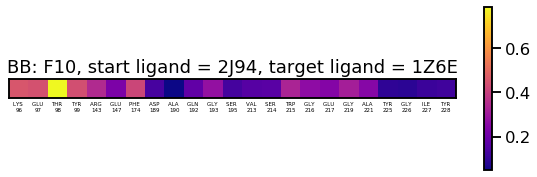

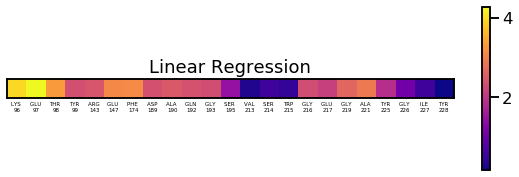

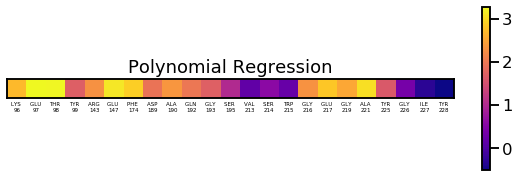

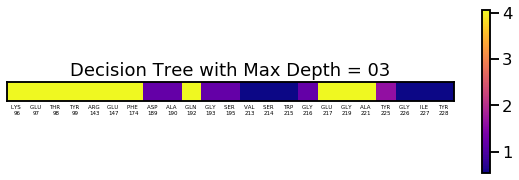

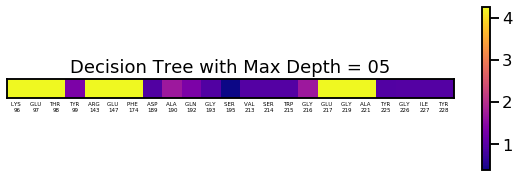

In [8]:
selected = data[(data['protein'] == test_prot) & (data['start ligand'] == '2J94') & (data['target ligand'] == '1Z6E')]
rmsd = np.array(selected['backbone rmsd'])
rmsd[rmsd > 8] = 8
rmsd_formatted = np.expand_dims(rmsd, axis=0)
sns.set_context("talk", font_scale=1.0)

plt.imshow(rmsd_formatted, cmap="plasma", interpolation='none')

fig = plt.gcf()
fig.set_size_inches(10,3)

ax = plt.gca()
labels = [r+'\n'+str(i) for r,i in zip(selected['name'], selected['num'])]
plt.xticks(np.arange(0,len(selected)),labels)
plt.yticks([],[])
ax.tick_params(axis=u'both', which=u'both',length=0)
ax.tick_params(axis='both', labelsize=5.5)

plt.colorbar()
plt.title('BB: F10, start ligand = 2J94, target ligand = 1Z6E')
plt.show()

bin_pred_rmsd_formatted = np.expand_dims(dict_models['Linear Regression']['y_pred'], axis=0)
sns.set_context("talk", font_scale=1.0)
plt.imshow(bin_pred_rmsd_formatted, cmap="plasma", interpolation='none')
fig = plt.gcf()
fig.set_size_inches(10,3)

ax = plt.gca()
labels = [r+'\n'+str(i) for r,i in zip(selected['name'], selected['num'])]
plt.xticks(np.arange(0,len(selected)),labels)
plt.yticks([],[])
ax.tick_params(axis=u'both', which=u'both',length=0)
ax.tick_params(axis='both', labelsize=5.5)

plt.colorbar()
plt.title('Linear Regression')
plt.show()

bin_pred_rmsd_formatted = np.expand_dims(dict_models['Polynomial Regression']['y_pred'], axis=0)
sns.set_context("talk", font_scale=1.0)
plt.imshow(bin_pred_rmsd_formatted, cmap="plasma", interpolation='none')
fig = plt.gcf()
fig.set_size_inches(10,3)

ax = plt.gca()
labels = [r+'\n'+str(i) for r,i in zip(selected['name'], selected['num'])]
plt.xticks(np.arange(0,len(selected)),labels)
plt.yticks([],[])
ax.tick_params(axis=u'both', which=u'both',length=0)
ax.tick_params(axis='both', labelsize=5.5)

plt.colorbar()
plt.title('Polynomial Regression')
plt.show()

bin_pred_rmsd_formatted = np.expand_dims(dict_models['Decision Tree with Max Depth = 03']['y_pred'], axis=0)
sns.set_context("talk", font_scale=1.0)
plt.imshow(bin_pred_rmsd_formatted, cmap="plasma", interpolation='none')
fig = plt.gcf()
fig.set_size_inches(10,3)

ax = plt.gca()
labels = [r+'\n'+str(i) for r,i in zip(selected['name'], selected['num'])]
plt.xticks(np.arange(0,len(selected)),labels)
plt.yticks([],[])
ax.tick_params(axis=u'both', which=u'both',length=0)
ax.tick_params(axis='both', labelsize=5.5)

plt.colorbar()
plt.title('Decision Tree with Max Depth = 03')
plt.show()

bin_pred_rmsd_formatted = np.expand_dims(dict_models['Decision Tree with Max Depth = 05']['y_pred'], axis=0)
sns.set_context("talk", font_scale=1.0)
plt.imshow(bin_pred_rmsd_formatted, cmap="plasma", interpolation='none')
fig = plt.gcf()
fig.set_size_inches(10,3)

ax = plt.gca()
labels = [r+'\n'+str(i) for r,i in zip(selected['name'], selected['num'])]
plt.xticks(np.arange(0,len(selected)),labels)
plt.yticks([],[])
ax.tick_params(axis=u'both', which=u'both',length=0)
ax.tick_params(axis='both', labelsize=5.5)

plt.colorbar()
plt.title('Decision Tree with Max Depth = 05')
plt.show()

In [9]:
files = os.listdir('../Data/rmsds')
first = True
data = pd.read_csv("../Data/rmsds/5HT2B_rmsds.csv")
for file in files:
    if file[-4:] == '.csv' and file != '5HT2B_rmsds.csv':
        fileData = pd.read_csv("../Data/rmsds/" + file)
        data = pd.concat([data, fileData], sort=False)
data = data[data['secondary structure'] != -1]
data = data[data['complete rmsd'] < 30]
prots = sorted(data['protein'].unique())

test_prot = 'F10'

print(test_prot)
train_data = data[data['protein'] != test_prot]
test_data = data[(data['protein'] == test_prot) & (data['start ligand'] == '2J94') & (data['target ligand'] == '1Z6E')]

test_data

X_train = train_data.drop(['protein', 'start ligand', 'target ligand', 'name', 'num', 'complete rmsd', 
                           'backbone rmsd', 'sidechain rmsd'], axis=1).values
Y_train = train_data['sidechain rmsd'].values 

X_test = test_data.drop(['protein', 'start ligand', 'target ligand', 'name', 'num', 'complete rmsd', 
                         'backbone rmsd', 'sidechain rmsd'], axis=1).values
Y_test = test_data['sidechain rmsd'].values 

X_true = X_train[Y_train > 2]
Y_true = Y_train[Y_train > 2]

X_train_expanded_50 = np.append(X_train, X_true, axis=0)
Y_train_expanded_50 = np.append(Y_train, Y_true, axis=0)

for i in range(4):
    X_train_expanded_50 = np.append(X_train_expanded_50, X_true, axis=0)
    Y_train_expanded_50 = np.append(Y_train_expanded_50, Y_true, axis=0)

dict_models = batch_classify(X_train_expanded_50, Y_train_expanded_50, X_test, Y_test, include_y_pred=True)
scores = scores_calculator(list(dict_classifiers.keys()), dict_models)
pd.DataFrame.from_dict(scores, orient='index')

F10
trained Linear Regression in 2.86 s
trained Polynomial Regression in 15.16 s

trained Decision Tree in 8.95 s

trained Decision Tree with Max Depth = 03 in 3.49 s

trained Decision Tree with Max Depth = 05 in 4.37 s

trained Decision Tree with Max Depth = 10 in 6.04 s

trained Decision Tree with Max Depth = 15 in 7.26 s


,Accuracy,Recall,Precision
Decision Tree,0.782609,1.0,0.375000
Decision Tree with Max Depth = 03,0.565217,1.0,0.230769
Decision Tree with Max Depth = 05,0.565217,1.0,0.230769
Decision Tree with Max Depth = 10,0.695652,1.0,0.300000
Decision Tree with Max Depth = 15,0.608696,1.0,0.250000
Linear Regression,0.347826,1.0,0.166667
Polynomial Regression,0.434783,1.0,0.187500


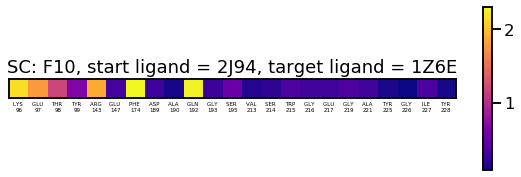

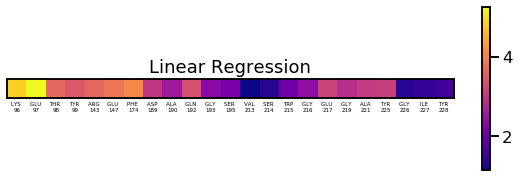

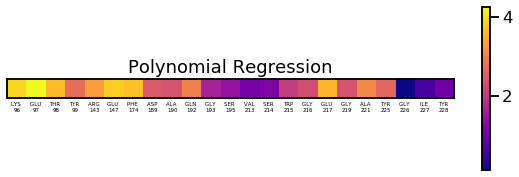

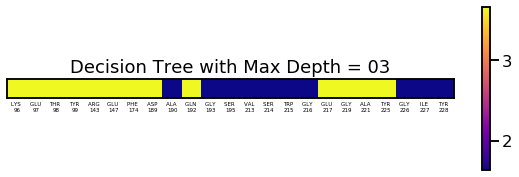

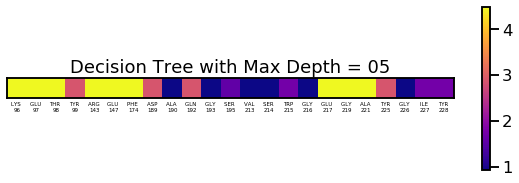

In [10]:
selected = data[(data['protein'] == test_prot) & (data['start ligand'] == '2J94') & (data['target ligand'] == '1Z6E')]
rmsd = np.array(selected['sidechain rmsd'])
rmsd[rmsd > 8] = 8
rmsd_formatted = np.expand_dims(rmsd, axis=0)
sns.set_context("talk", font_scale=1.0)

plt.imshow(rmsd_formatted, cmap="plasma", interpolation='none')

fig = plt.gcf()
fig.set_size_inches(10,3)

ax = plt.gca()
labels = [r+'\n'+str(i) for r,i in zip(selected['name'], selected['num'])]
plt.xticks(np.arange(0,len(selected)),labels)
plt.yticks([],[])
ax.tick_params(axis=u'both', which=u'both',length=0)
ax.tick_params(axis='both', labelsize=5.5)

plt.colorbar()
plt.title('SC: F10, start ligand = 2J94, target ligand = 1Z6E')
plt.show()

bin_pred_rmsd_formatted = np.expand_dims(dict_models['Linear Regression']['y_pred'], axis=0)
sns.set_context("talk", font_scale=1.0)
plt.imshow(bin_pred_rmsd_formatted, cmap="plasma", interpolation='none')
fig = plt.gcf()
fig.set_size_inches(10,3)

ax = plt.gca()
labels = [r+'\n'+str(i) for r,i in zip(selected['name'], selected['num'])]
plt.xticks(np.arange(0,len(selected)),labels)
plt.yticks([],[])
ax.tick_params(axis=u'both', which=u'both',length=0)
ax.tick_params(axis='both', labelsize=5.5)

plt.colorbar()
plt.title('Linear Regression')
plt.show()

bin_pred_rmsd_formatted = np.expand_dims(dict_models['Polynomial Regression']['y_pred'], axis=0)
sns.set_context("talk", font_scale=1.0)
plt.imshow(bin_pred_rmsd_formatted, cmap="plasma", interpolation='none')
fig = plt.gcf()
fig.set_size_inches(10,3)

ax = plt.gca()
labels = [r+'\n'+str(i) for r,i in zip(selected['name'], selected['num'])]
plt.xticks(np.arange(0,len(selected)),labels)
plt.yticks([],[])
ax.tick_params(axis=u'both', which=u'both',length=0)
ax.tick_params(axis='both', labelsize=5.5)

plt.colorbar()
plt.title('Polynomial Regression')
plt.show()

bin_pred_rmsd_formatted = np.expand_dims(dict_models['Decision Tree with Max Depth = 03']['y_pred'], axis=0)
sns.set_context("talk", font_scale=1.0)
plt.imshow(bin_pred_rmsd_formatted, cmap="plasma", interpolation='none')
fig = plt.gcf()
fig.set_size_inches(10,3)

ax = plt.gca()
labels = [r+'\n'+str(i) for r,i in zip(selected['name'], selected['num'])]
plt.xticks(np.arange(0,len(selected)),labels)
plt.yticks([],[])
ax.tick_params(axis=u'both', which=u'both',length=0)
ax.tick_params(axis='both', labelsize=5.5)

plt.colorbar()
plt.title('Decision Tree with Max Depth = 03')
plt.show()

bin_pred_rmsd_formatted = np.expand_dims(dict_models['Decision Tree with Max Depth = 05']['y_pred'], axis=0)
sns.set_context("talk", font_scale=1.0)
plt.imshow(bin_pred_rmsd_formatted, cmap="plasma", interpolation='none')
fig = plt.gcf()
fig.set_size_inches(10,3)

ax = plt.gca()
labels = [r+'\n'+str(i) for r,i in zip(selected['name'], selected['num'])]
plt.xticks(np.arange(0,len(selected)),labels)
plt.yticks([],[])
ax.tick_params(axis=u'both', which=u'both',length=0)
ax.tick_params(axis='both', labelsize=5.5)

plt.colorbar()
plt.title('Decision Tree with Max Depth = 05')
plt.show()

In [11]:
files = os.listdir('../Data/rmsds')
first = True
data = pd.read_csv("../Data/rmsds/5HT2B_rmsds.csv")
for file in files:
    if file[-4:] == '.csv' and file != '5HT2B_rmsds.csv':
        fileData = pd.read_csv("../Data/rmsds/" + file)
        data = pd.concat([data, fileData], sort=False)
data = data[data['secondary structure'] != -1]
data = data[data['complete rmsd'] < 30]
prots = sorted(data['protein'].unique())

test_prot = 'NR3C2'

print(test_prot)
train_data = data[data['protein'] != test_prot]
test_data = data[(data['protein'] == test_prot) & (data['start ligand'] == '2A3I') & (data['target ligand'] == '5MWP')]

test_data

X_train = train_data.drop(['protein', 'start ligand', 'target ligand', 'name', 'num', 'complete rmsd', 
                           'backbone rmsd', 'sidechain rmsd'], axis=1).values
Y_train = train_data['backbone rmsd'].values 

X_test = test_data.drop(['protein', 'start ligand', 'target ligand', 'name', 'num', 'complete rmsd', 
                         'backbone rmsd', 'sidechain rmsd'], axis=1).values
Y_test = test_data['backbone rmsd'].values 

X_true = X_train[Y_train > 2]
Y_true = Y_train[Y_train > 2]

X_train_expanded_50 = np.append(X_train, X_true, axis=0)
Y_train_expanded_50 = np.append(Y_train, Y_true, axis=0)

for i in range(4):
    X_train_expanded_50 = np.append(X_train_expanded_50, X_true, axis=0)
    Y_train_expanded_50 = np.append(Y_train_expanded_50, Y_true, axis=0)

dict_models = batch_classify(X_train_expanded_50, Y_train_expanded_50, X_test, Y_test, include_y_pred=True)
scores = scores_calculator(list(dict_classifiers.keys()), dict_models)
pd.DataFrame.from_dict(scores, orient='index')

NR3C2
trained Linear Regression in 2.03 s
trained Polynomial Regression in 11.36 s

trained Decision Tree in 7.97 s

trained Decision Tree with Max Depth = 03 in 3.00 s

trained Decision Tree with Max Depth = 05 in 3.77 s

trained Decision Tree with Max Depth = 10 in 4.92 s

trained Decision Tree with Max Depth = 15 in 5.75 s


,Accuracy,Recall,Precision
Decision Tree,1.00,None,NaN
Decision Tree with Max Depth = 03,1.00,None,NaN
Decision Tree with Max Depth = 05,0.96,None,0.0
Decision Tree with Max Depth = 10,0.96,None,0.0
Decision Tree with Max Depth = 15,0.96,None,0.0
Linear Regression,1.00,None,NaN
Polynomial Regression,1.00,None,NaN


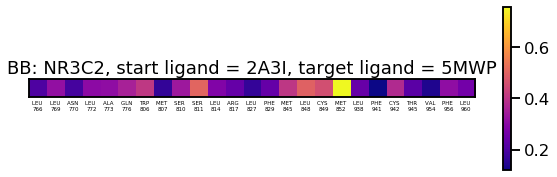

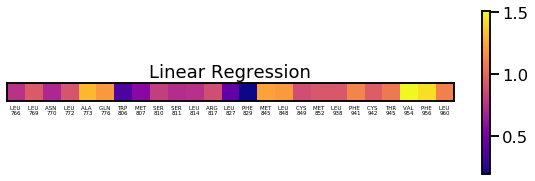

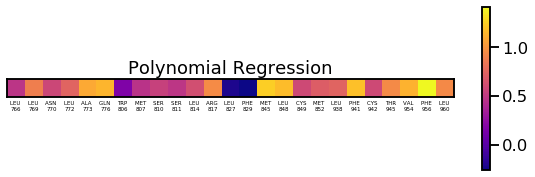

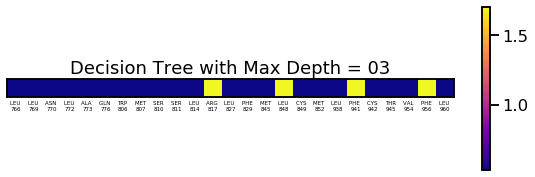

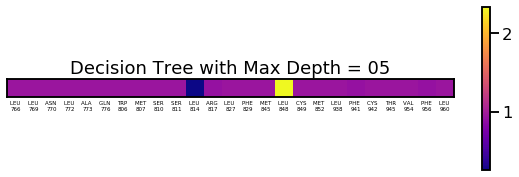

In [12]:
selected = data[(data['protein'] == test_prot) & (data['start ligand'] == '2A3I') & (data['target ligand'] == '5MWP')]
rmsd = np.array(selected['backbone rmsd'])
rmsd[rmsd > 8] = 8
rmsd_formatted = np.expand_dims(rmsd, axis=0)
sns.set_context("talk", font_scale=1.0)

plt.imshow(rmsd_formatted, cmap="plasma", interpolation='none')

fig = plt.gcf()
fig.set_size_inches(10,3)

ax = plt.gca()
labels = [r+'\n'+str(i) for r,i in zip(selected['name'], selected['num'])]
plt.xticks(np.arange(0,len(selected)),labels)
plt.yticks([],[])
ax.tick_params(axis=u'both', which=u'both',length=0)
ax.tick_params(axis='both', labelsize=5.5)

plt.colorbar()
plt.title('BB: NR3C2, start ligand = 2A3I, target ligand = 5MWP')
plt.show()

bin_pred_rmsd_formatted = np.expand_dims(dict_models['Linear Regression']['y_pred'], axis=0)
sns.set_context("talk", font_scale=1.0)
plt.imshow(bin_pred_rmsd_formatted, cmap="plasma", interpolation='none')
fig = plt.gcf()
fig.set_size_inches(10,3)

ax = plt.gca()
labels = [r+'\n'+str(i) for r,i in zip(selected['name'], selected['num'])]
plt.xticks(np.arange(0,len(selected)),labels)
plt.yticks([],[])
ax.tick_params(axis=u'both', which=u'both',length=0)
ax.tick_params(axis='both', labelsize=5.5)

plt.colorbar()
plt.title('Linear Regression')
plt.show()

bin_pred_rmsd_formatted = np.expand_dims(dict_models['Polynomial Regression']['y_pred'], axis=0)
sns.set_context("talk", font_scale=1.0)
plt.imshow(bin_pred_rmsd_formatted, cmap="plasma", interpolation='none')
fig = plt.gcf()
fig.set_size_inches(10,3)

ax = plt.gca()
labels = [r+'\n'+str(i) for r,i in zip(selected['name'], selected['num'])]
plt.xticks(np.arange(0,len(selected)),labels)
plt.yticks([],[])
ax.tick_params(axis=u'both', which=u'both',length=0)
ax.tick_params(axis='both', labelsize=5.5)

plt.colorbar()
plt.title('Polynomial Regression')
plt.show()

bin_pred_rmsd_formatted = np.expand_dims(dict_models['Decision Tree with Max Depth = 03']['y_pred'], axis=0)
sns.set_context("talk", font_scale=1.0)
plt.imshow(bin_pred_rmsd_formatted, cmap="plasma", interpolation='none')
fig = plt.gcf()
fig.set_size_inches(10,3)

ax = plt.gca()
labels = [r+'\n'+str(i) for r,i in zip(selected['name'], selected['num'])]
plt.xticks(np.arange(0,len(selected)),labels)
plt.yticks([],[])
ax.tick_params(axis=u'both', which=u'both',length=0)
ax.tick_params(axis='both', labelsize=5.5)

plt.colorbar()
plt.title('Decision Tree with Max Depth = 03')
plt.show()

bin_pred_rmsd_formatted = np.expand_dims(dict_models['Decision Tree with Max Depth = 05']['y_pred'], axis=0)
sns.set_context("talk", font_scale=1.0)
plt.imshow(bin_pred_rmsd_formatted, cmap="plasma", interpolation='none')
fig = plt.gcf()
fig.set_size_inches(10,3)

ax = plt.gca()
labels = [r+'\n'+str(i) for r,i in zip(selected['name'], selected['num'])]
plt.xticks(np.arange(0,len(selected)),labels)
plt.yticks([],[])
ax.tick_params(axis=u'both', which=u'both',length=0)
ax.tick_params(axis='both', labelsize=5.5)

plt.colorbar()
plt.title('Decision Tree with Max Depth = 05')
plt.show()

In [13]:
files = os.listdir('../Data/rmsds')
first = True
data = pd.read_csv("../Data/rmsds/5HT2B_rmsds.csv")
for file in files:
    if file[-4:] == '.csv' and file != '5HT2B_rmsds.csv':
        fileData = pd.read_csv("../Data/rmsds/" + file)
        data = pd.concat([data, fileData], sort=False)
data = data[data['secondary structure'] != -1]
data = data[data['complete rmsd'] < 30]
prots = sorted(data['protein'].unique())

test_prot = 'NR3C2'

print(test_prot)
train_data = data[data['protein'] != test_prot]
test_data = data[(data['protein'] == test_prot) & (data['start ligand'] == '2A3I') & (data['target ligand'] == '5MWP')]

test_data

X_train = train_data.drop(['protein', 'start ligand', 'target ligand', 'name', 'num', 'complete rmsd', 
                           'backbone rmsd', 'sidechain rmsd'], axis=1).values
Y_train = train_data['sidechain rmsd'].values 

X_test = test_data.drop(['protein', 'start ligand', 'target ligand', 'name', 'num', 'complete rmsd', 
                         'backbone rmsd', 'sidechain rmsd'], axis=1).values
Y_test = test_data['sidechain rmsd'].values 

X_true = X_train[Y_train > 2]
Y_true = Y_train[Y_train > 2]

X_train_expanded_50 = np.append(X_train, X_true, axis=0)
Y_train_expanded_50 = np.append(Y_train, Y_true, axis=0)

for i in range(4):
    X_train_expanded_50 = np.append(X_train_expanded_50, X_true, axis=0)
    Y_train_expanded_50 = np.append(Y_train_expanded_50, Y_true, axis=0)

dict_models = batch_classify(X_train_expanded_50, Y_train_expanded_50, X_test, Y_test, include_y_pred=True)
scores = scores_calculator(list(dict_classifiers.keys()), dict_models)
pd.DataFrame.from_dict(scores, orient='index')

NR3C2
trained Linear Regression in 3.00 s
trained Polynomial Regression in 16.64 s

trained Decision Tree in 9.11 s

trained Decision Tree with Max Depth = 03 in 3.50 s

trained Decision Tree with Max Depth = 05 in 4.43 s

trained Decision Tree with Max Depth = 10 in 5.91 s

trained Decision Tree with Max Depth = 15 in 7.07 s


,Accuracy,Recall,Precision
Decision Tree,0.84,0.2,1.000000
Decision Tree with Max Depth = 03,0.72,0.2,0.250000
Decision Tree with Max Depth = 05,0.72,0.2,0.250000
Decision Tree with Max Depth = 10,0.80,0.4,0.500000
Decision Tree with Max Depth = 15,0.80,0.0,NaN
Linear Regression,0.72,0.4,0.333333
Polynomial Regression,0.72,0.2,0.250000


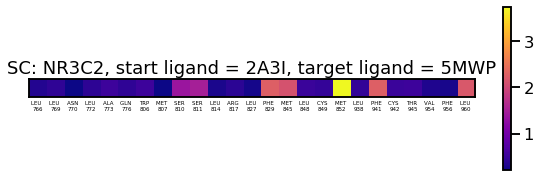

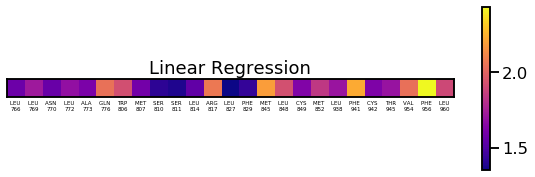

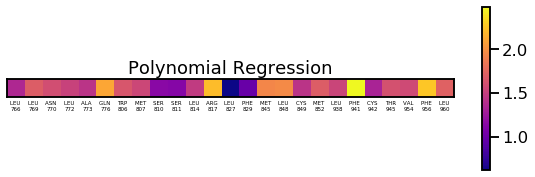

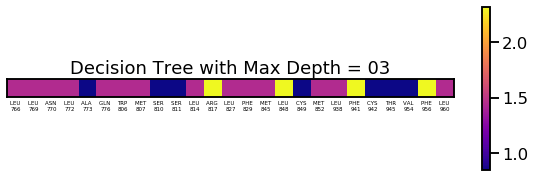

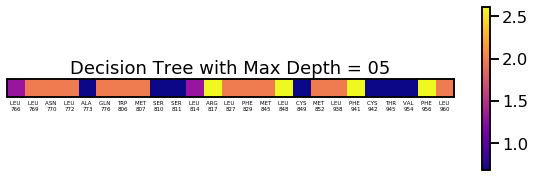

In [14]:
selected = data[(data['protein'] == test_prot) & (data['start ligand'] == '2A3I') & (data['target ligand'] == '5MWP')]
rmsd = np.array(selected['sidechain rmsd'])
rmsd[rmsd > 8] = 8
rmsd_formatted = np.expand_dims(rmsd, axis=0)
sns.set_context("talk", font_scale=1.0)

plt.imshow(rmsd_formatted, cmap="plasma", interpolation='none')

fig = plt.gcf()
fig.set_size_inches(10,3)

ax = plt.gca()
labels = [r+'\n'+str(i) for r,i in zip(selected['name'], selected['num'])]
plt.xticks(np.arange(0,len(selected)),labels)
plt.yticks([],[])
ax.tick_params(axis=u'both', which=u'both',length=0)
ax.tick_params(axis='both', labelsize=5.5)

plt.colorbar()
plt.title('SC: NR3C2, start ligand = 2A3I, target ligand = 5MWP')
plt.show()

bin_pred_rmsd_formatted = np.expand_dims(dict_models['Linear Regression']['y_pred'], axis=0)
sns.set_context("talk", font_scale=1.0)
plt.imshow(bin_pred_rmsd_formatted, cmap="plasma", interpolation='none')
fig = plt.gcf()
fig.set_size_inches(10,3)

ax = plt.gca()
labels = [r+'\n'+str(i) for r,i in zip(selected['name'], selected['num'])]
plt.xticks(np.arange(0,len(selected)),labels)
plt.yticks([],[])
ax.tick_params(axis=u'both', which=u'both',length=0)
ax.tick_params(axis='both', labelsize=5.5)

plt.colorbar()
plt.title('Linear Regression')
plt.show()

bin_pred_rmsd_formatted = np.expand_dims(dict_models['Polynomial Regression']['y_pred'], axis=0)
sns.set_context("talk", font_scale=1.0)
plt.imshow(bin_pred_rmsd_formatted, cmap="plasma", interpolation='none')
fig = plt.gcf()
fig.set_size_inches(10,3)

ax = plt.gca()
labels = [r+'\n'+str(i) for r,i in zip(selected['name'], selected['num'])]
plt.xticks(np.arange(0,len(selected)),labels)
plt.yticks([],[])
ax.tick_params(axis=u'both', which=u'both',length=0)
ax.tick_params(axis='both', labelsize=5.5)

plt.colorbar()
plt.title('Polynomial Regression')
plt.show()

bin_pred_rmsd_formatted = np.expand_dims(dict_models['Decision Tree with Max Depth = 03']['y_pred'], axis=0)
sns.set_context("talk", font_scale=1.0)
plt.imshow(bin_pred_rmsd_formatted, cmap="plasma", interpolation='none')
fig = plt.gcf()
fig.set_size_inches(10,3)

ax = plt.gca()
labels = [r+'\n'+str(i) for r,i in zip(selected['name'], selected['num'])]
plt.xticks(np.arange(0,len(selected)),labels)
plt.yticks([],[])
ax.tick_params(axis=u'both', which=u'both',length=0)
ax.tick_params(axis='both', labelsize=5.5)

plt.colorbar()
plt.title('Decision Tree with Max Depth = 03')
plt.show()

bin_pred_rmsd_formatted = np.expand_dims(dict_models['Decision Tree with Max Depth = 05']['y_pred'], axis=0)
sns.set_context("talk", font_scale=1.0)
plt.imshow(bin_pred_rmsd_formatted, cmap="plasma", interpolation='none')
fig = plt.gcf()
fig.set_size_inches(10,3)

ax = plt.gca()
labels = [r+'\n'+str(i) for r,i in zip(selected['name'], selected['num'])]
plt.xticks(np.arange(0,len(selected)),labels)
plt.yticks([],[])
ax.tick_params(axis=u'both', which=u'both',length=0)
ax.tick_params(axis='both', labelsize=5.5)

plt.colorbar()
plt.title('Decision Tree with Max Depth = 05')
plt.show()

In [19]:
files = os.listdir('../Data/rmsds')
first = True
data = pd.read_csv("../Data/rmsds/5HT2B_rmsds.csv")
for file in files:
    if file[-4:] == '.csv' and file != '5HT2B_rmsds.csv':
        fileData = pd.read_csv("../Data/rmsds/" + file)
        data = pd.concat([data, fileData], sort=False)
data = data[data['secondary structure'] != -1]
data = data[data['complete rmsd'] < 30]
prots = sorted(data['protein'].unique())

test_prot = 'MAPK14'

print(test_prot)
train_data = data[data['protein'] != test_prot]
test_data = data[(data['protein'] == test_prot) & (data['start ligand'] == '2YIX') & (data['target ligand'] == '3D83')]

test_data

X_train = train_data.drop(['protein', 'start ligand', 'target ligand', 'name', 'num', 'complete rmsd', 
                           'backbone rmsd', 'sidechain rmsd'], axis=1).values
Y_train = train_data['backbone rmsd'].values 

X_test = test_data.drop(['protein', 'start ligand', 'target ligand', 'name', 'num', 'complete rmsd', 
                         'backbone rmsd', 'sidechain rmsd'], axis=1).values
Y_test = test_data['backbone rmsd'].values 

X_true = X_train[Y_train > 2]
Y_true = Y_train[Y_train > 2]

X_train_expanded_50 = np.append(X_train, X_true, axis=0)
Y_train_expanded_50 = np.append(Y_train, Y_true, axis=0)

for i in range(4):
    X_train_expanded_50 = np.append(X_train_expanded_50, X_true, axis=0)
    Y_train_expanded_50 = np.append(Y_train_expanded_50, Y_true, axis=0)

dict_models = batch_classify(X_train_expanded_50, Y_train_expanded_50, X_test, Y_test, include_y_pred=True)
scores = scores_calculator(list(dict_classifiers.keys()), dict_models)
pd.DataFrame.from_dict(scores, orient='index')

MAPK14
trained Linear Regression in 1.77 s
trained Polynomial Regression in 11.23 s

trained Decision Tree in 7.42 s

trained Decision Tree with Max Depth = 03 in 2.85 s

trained Decision Tree with Max Depth = 05 in 3.48 s

trained Decision Tree with Max Depth = 10 in 4.51 s

trained Decision Tree with Max Depth = 15 in 5.42 s


,Accuracy,Recall,Precision
Decision Tree,0.787879,0.000000,NaN
Decision Tree with Max Depth = 03,0.787879,0.000000,NaN
Decision Tree with Max Depth = 05,0.666667,0.142857,0.166667
Decision Tree with Max Depth = 10,0.757576,0.142857,0.333333
Decision Tree with Max Depth = 15,0.787879,0.142857,0.500000
Linear Regression,0.757576,0.142857,0.333333
Polynomial Regression,0.757576,0.142857,0.333333


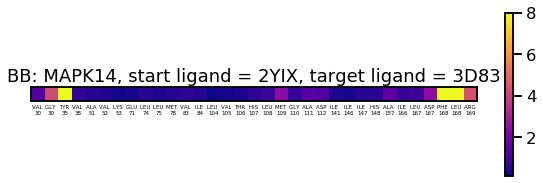

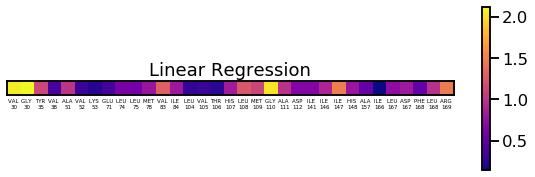

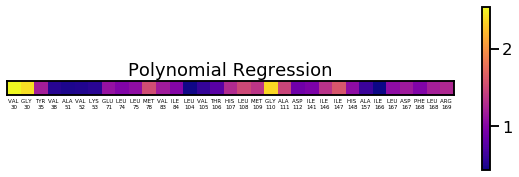

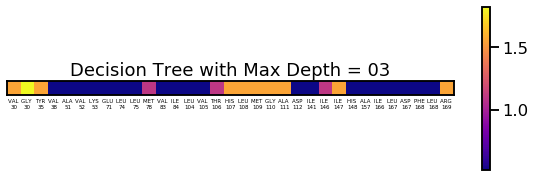

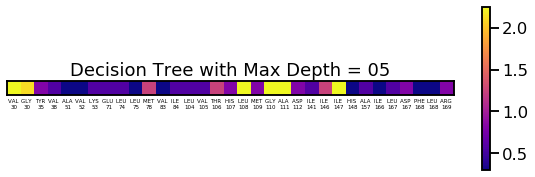

In [16]:
selected = data[(data['protein'] == test_prot) & (data['start ligand'] == '2YIX') & (data['target ligand'] == '3D83')]
rmsd = np.array(selected['backbone rmsd'])
rmsd[rmsd > 8] = 8
rmsd_formatted = np.expand_dims(rmsd, axis=0)
sns.set_context("talk", font_scale=1.0)

plt.imshow(rmsd_formatted, cmap="plasma", interpolation='none')

fig = plt.gcf()
fig.set_size_inches(10,3)

ax = plt.gca()
labels = [r+'\n'+str(i) for r,i in zip(selected['name'], selected['num'])]
plt.xticks(np.arange(0,len(selected)),labels)
plt.yticks([],[])
ax.tick_params(axis=u'both', which=u'both',length=0)
ax.tick_params(axis='both', labelsize=5.5)

plt.colorbar()
plt.title('BB: MAPK14, start ligand = 2YIX, target ligand = 3D83')
plt.show()

bin_pred_rmsd_formatted = np.expand_dims(dict_models['Linear Regression']['y_pred'], axis=0)
sns.set_context("talk", font_scale=1.0)
plt.imshow(bin_pred_rmsd_formatted, cmap="plasma", interpolation='none')
fig = plt.gcf()
fig.set_size_inches(10,3)

ax = plt.gca()
labels = [r+'\n'+str(i) for r,i in zip(selected['name'], selected['num'])]
plt.xticks(np.arange(0,len(selected)),labels)
plt.yticks([],[])
ax.tick_params(axis=u'both', which=u'both',length=0)
ax.tick_params(axis='both', labelsize=5.5)

plt.colorbar()
plt.title('Linear Regression')
plt.show()

bin_pred_rmsd_formatted = np.expand_dims(dict_models['Polynomial Regression']['y_pred'], axis=0)
sns.set_context("talk", font_scale=1.0)
plt.imshow(bin_pred_rmsd_formatted, cmap="plasma", interpolation='none')
fig = plt.gcf()
fig.set_size_inches(10,3)

ax = plt.gca()
labels = [r+'\n'+str(i) for r,i in zip(selected['name'], selected['num'])]
plt.xticks(np.arange(0,len(selected)),labels)
plt.yticks([],[])
ax.tick_params(axis=u'both', which=u'both',length=0)
ax.tick_params(axis='both', labelsize=5.5)

plt.colorbar()
plt.title('Polynomial Regression')
plt.show()

bin_pred_rmsd_formatted = np.expand_dims(dict_models['Decision Tree with Max Depth = 03']['y_pred'], axis=0)
sns.set_context("talk", font_scale=1.0)
plt.imshow(bin_pred_rmsd_formatted, cmap="plasma", interpolation='none')
fig = plt.gcf()
fig.set_size_inches(10,3)

ax = plt.gca()
labels = [r+'\n'+str(i) for r,i in zip(selected['name'], selected['num'])]
plt.xticks(np.arange(0,len(selected)),labels)
plt.yticks([],[])
ax.tick_params(axis=u'both', which=u'both',length=0)
ax.tick_params(axis='both', labelsize=5.5)

plt.colorbar()
plt.title('Decision Tree with Max Depth = 03')
plt.show()

bin_pred_rmsd_formatted = np.expand_dims(dict_models['Decision Tree with Max Depth = 05']['y_pred'], axis=0)
sns.set_context("talk", font_scale=1.0)
plt.imshow(bin_pred_rmsd_formatted, cmap="plasma", interpolation='none')
fig = plt.gcf()
fig.set_size_inches(10,3)

ax = plt.gca()
labels = [r+'\n'+str(i) for r,i in zip(selected['name'], selected['num'])]
plt.xticks(np.arange(0,len(selected)),labels)
plt.yticks([],[])
ax.tick_params(axis=u'both', which=u'both',length=0)
ax.tick_params(axis='both', labelsize=5.5)

plt.colorbar()
plt.title('Decision Tree with Max Depth = 05')
plt.show()

In [17]:
files = os.listdir('../Data/rmsds')
first = True
data = pd.read_csv("../Data/rmsds/5HT2B_rmsds.csv")
for file in files:
    if file[-4:] == '.csv' and file != '5HT2B_rmsds.csv':
        fileData = pd.read_csv("../Data/rmsds/" + file)
        data = pd.concat([data, fileData], sort=False)
data = data[data['secondary structure'] != -1]
data = data[data['complete rmsd'] < 30]
prots = sorted(data['protein'].unique())

test_prot = 'MAPK14'

print(test_prot)
train_data = data[data['protein'] != test_prot]
test_data = data[(data['protein'] == test_prot) & (data['start ligand'] == '2YIX') & (data['target ligand'] == '3D83')]

test_data

X_train = train_data.drop(['protein', 'start ligand', 'target ligand', 'name', 'num', 'complete rmsd', 
                           'backbone rmsd', 'sidechain rmsd'], axis=1).values
Y_train = train_data['sidechain rmsd'].values 

X_test = test_data.drop(['protein', 'start ligand', 'target ligand', 'name', 'num', 'complete rmsd', 
                         'backbone rmsd', 'sidechain rmsd'], axis=1).values
Y_test = test_data['sidechain rmsd'].values 

X_true = X_train[Y_train > 2]
Y_true = Y_train[Y_train > 2]

X_train_expanded_50 = np.append(X_train, X_true, axis=0)
Y_train_expanded_50 = np.append(Y_train, Y_true, axis=0)

for i in range(4):
    X_train_expanded_50 = np.append(X_train_expanded_50, X_true, axis=0)
    Y_train_expanded_50 = np.append(Y_train_expanded_50, Y_true, axis=0)

dict_models = batch_classify(X_train_expanded_50, Y_train_expanded_50, X_test, Y_test, include_y_pred=True)
scores = scores_calculator(list(dict_classifiers.keys()), dict_models)
pd.DataFrame.from_dict(scores, orient='index')

MAPK14
trained Linear Regression in 2.71 s
trained Polynomial Regression in 14.67 s

trained Decision Tree in 8.60 s

trained Decision Tree with Max Depth = 03 in 3.34 s

trained Decision Tree with Max Depth = 05 in 4.37 s

trained Decision Tree with Max Depth = 10 in 5.58 s

trained Decision Tree with Max Depth = 15 in 6.63 s


,Accuracy,Recall,Precision
Decision Tree,0.636364,0.1,0.250000
Decision Tree with Max Depth = 03,0.636364,0.4,0.400000
Decision Tree with Max Depth = 05,0.636364,0.4,0.400000
Decision Tree with Max Depth = 10,0.727273,0.2,0.666667
Decision Tree with Max Depth = 15,0.666667,0.1,0.333333
Linear Regression,0.696970,0.3,0.500000
Polynomial Regression,0.575758,0.3,0.300000


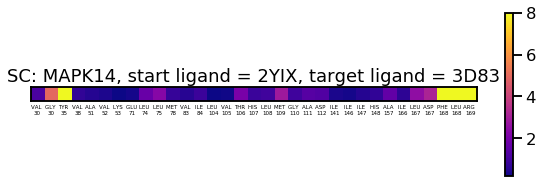

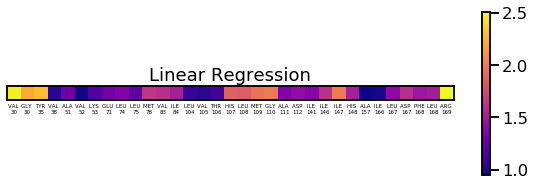

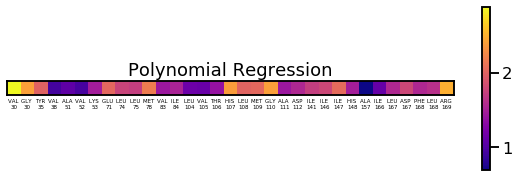

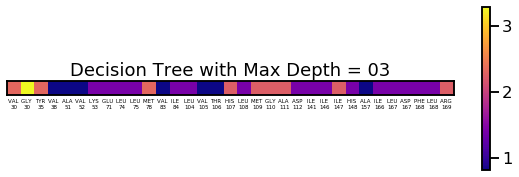

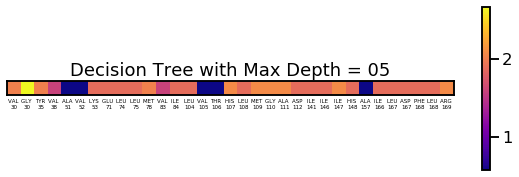

In [18]:
selected = data[(data['protein'] == test_prot) & (data['start ligand'] == '2YIX') & (data['target ligand'] == '3D83')]
rmsd = np.array(selected['sidechain rmsd'])
rmsd[rmsd > 8] = 8
rmsd_formatted = np.expand_dims(rmsd, axis=0)
sns.set_context("talk", font_scale=1.0)

plt.imshow(rmsd_formatted, cmap="plasma", interpolation='none')

fig = plt.gcf()
fig.set_size_inches(10,3)

ax = plt.gca()
labels = [r+'\n'+str(i) for r,i in zip(selected['name'], selected['num'])]
plt.xticks(np.arange(0,len(selected)),labels)
plt.yticks([],[])
ax.tick_params(axis=u'both', which=u'both',length=0)
ax.tick_params(axis='both', labelsize=5.5)

plt.colorbar()
plt.title('SC: MAPK14, start ligand = 2YIX, target ligand = 3D83')
plt.show()

bin_pred_rmsd_formatted = np.expand_dims(dict_models['Linear Regression']['y_pred'], axis=0)
sns.set_context("talk", font_scale=1.0)
plt.imshow(bin_pred_rmsd_formatted, cmap="plasma", interpolation='none')
fig = plt.gcf()
fig.set_size_inches(10,3)

ax = plt.gca()
labels = [r+'\n'+str(i) for r,i in zip(selected['name'], selected['num'])]
plt.xticks(np.arange(0,len(selected)),labels)
plt.yticks([],[])
ax.tick_params(axis=u'both', which=u'both',length=0)
ax.tick_params(axis='both', labelsize=5.5)

plt.colorbar()
plt.title('Linear Regression')
plt.show()

bin_pred_rmsd_formatted = np.expand_dims(dict_models['Polynomial Regression']['y_pred'], axis=0)
sns.set_context("talk", font_scale=1.0)
plt.imshow(bin_pred_rmsd_formatted, cmap="plasma", interpolation='none')
fig = plt.gcf()
fig.set_size_inches(10,3)

ax = plt.gca()
labels = [r+'\n'+str(i) for r,i in zip(selected['name'], selected['num'])]
plt.xticks(np.arange(0,len(selected)),labels)
plt.yticks([],[])
ax.tick_params(axis=u'both', which=u'both',length=0)
ax.tick_params(axis='both', labelsize=5.5)

plt.colorbar()
plt.title('Polynomial Regression')
plt.show()

bin_pred_rmsd_formatted = np.expand_dims(dict_models['Decision Tree with Max Depth = 03']['y_pred'], axis=0)
sns.set_context("talk", font_scale=1.0)
plt.imshow(bin_pred_rmsd_formatted, cmap="plasma", interpolation='none')
fig = plt.gcf()
fig.set_size_inches(10,3)

ax = plt.gca()
labels = [r+'\n'+str(i) for r,i in zip(selected['name'], selected['num'])]
plt.xticks(np.arange(0,len(selected)),labels)
plt.yticks([],[])
ax.tick_params(axis=u'both', which=u'both',length=0)
ax.tick_params(axis='both', labelsize=5.5)

plt.colorbar()
plt.title('Decision Tree with Max Depth = 03')
plt.show()

bin_pred_rmsd_formatted = np.expand_dims(dict_models['Decision Tree with Max Depth = 05']['y_pred'], axis=0)
sns.set_context("talk", font_scale=1.0)
plt.imshow(bin_pred_rmsd_formatted, cmap="plasma", interpolation='none')
fig = plt.gcf()
fig.set_size_inches(10,3)

ax = plt.gca()
labels = [r+'\n'+str(i) for r,i in zip(selected['name'], selected['num'])]
plt.xticks(np.arange(0,len(selected)),labels)
plt.yticks([],[])
ax.tick_params(axis=u'both', which=u'both',length=0)
ax.tick_params(axis='both', labelsize=5.5)

plt.colorbar()
plt.title('Decision Tree with Max Depth = 05')
plt.show()

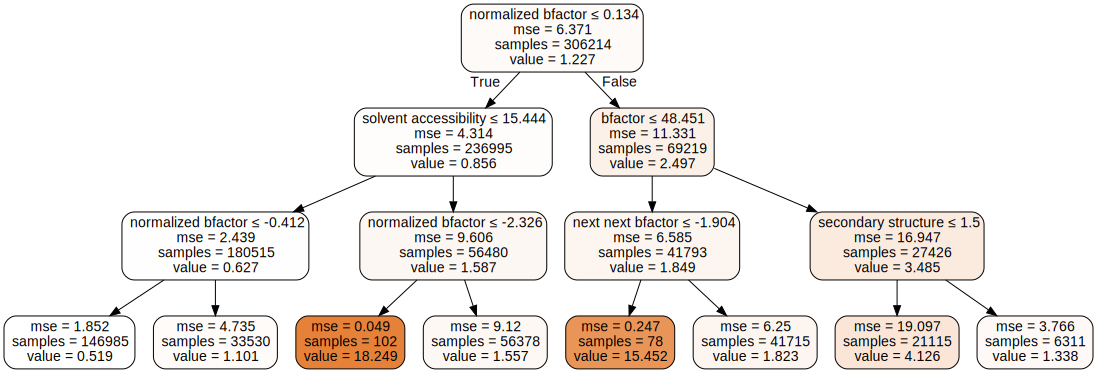

In [20]:
dot_data = tree.export_graphviz(dict_classifiers['Decision Tree with Max Depth = 03'], out_file=None, feature_names=data.columns[5:18], filled=True, rounded=True, special_characters=True)  
graph = graphviz.Source(dot_data)
graph